# Homework #7: Due October 28th, 2021, 11:59pm
## Hamiltonian Monte Carlo for Bayesian Logistic Regression

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
import autograd.numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc3 import Model
import pymc3 as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem Description: Inference for Bayesian Logistic Regression Models
In In-Class Exercise 10.13, we studied the problem of how to evaluate the classification probabilites outputed by a Logistic Regression model using calibration plots. Calibration plots are computed using observed data (data that is part of or similar to our training set). In this homework, we evaluate the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic Regression models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.


### Part I: Interpreting the Classification Probabilites of Logistic Regression as Uncertainties

**Exercise 1: (Classifying OOD MNIST Digits)** In In-Class Exercise 10.13, we interpreted the output of a Logistic Regression model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0). Explain why this is a reasonable interpretation of the classification probability. 

In this Exercise, build a Logistic Regression model to distinguish between digital images of handwritten digits (this is the MNIST dataset):

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`

For simplicity, we only look at images of digits: 1 and 6. 

In this dataset, the classes are balanced (we take 600 images of each digit). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of six test images,
`test_point_1`, ..., `test_point_6`,
report the classification probabiliy for each image under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test images.

So is this classifier a good model? Does your analysis of the model's performance via its predictive accuracy agree with your analysis of the model's performance via its predictive uncertainties? Conclude whether or not you would feel comfortable using this model in a real-life setting?

In [3]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
# Pick out two classes of digits: 1, 6 and take a subset of samples
X_subset = X[((y == '1') | (y == '6'))][0:600]
y_subset = y[((y == '1') | (y == '6'))][0:600]

# Encode the label '1' with y=1, and the label '6' with y=0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '6'] = 0
y_subset = y_subset.astype(int)

In [5]:
# Randomize our data
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset[permutation]
y_subset = y_subset[permutation]
X_subset = X_subset.reshape((X_subset.shape[0], -1))

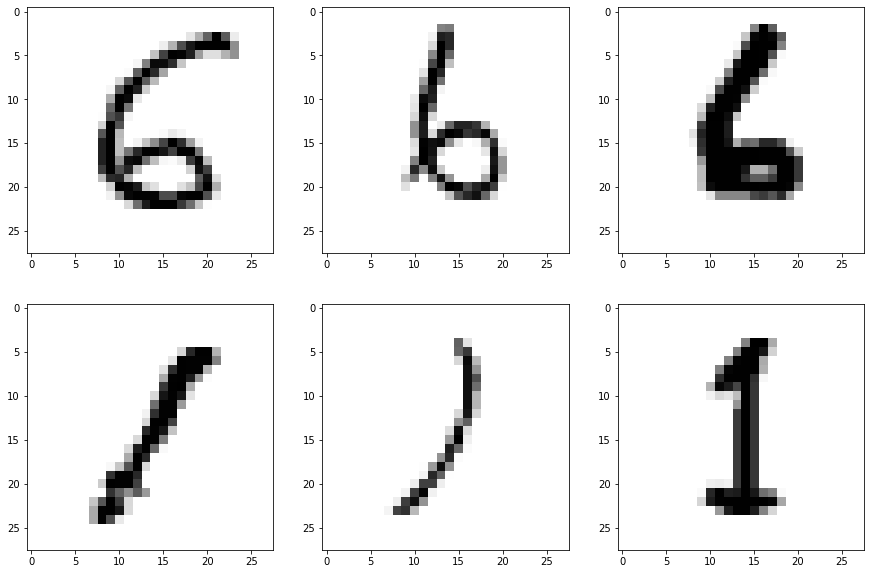

In [234]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == 0][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1, i].imshow(X_subset[y_subset == 1][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [235]:
# Test images for evaluating your classifier
test_point_1 = X_subset[y_subset == 0][10]
test_point_2 = X_subset[y_subset == 1][10]
test_point_3 = X[y=='3'][20]
test_point_4 = np.random.normal(200, 10, size=(28 * 28, ))
test_point_5 = test_point_2 + np.random.normal(300, 10, size=(28 * 28, )) - test_point_1
test_point_6 = test_point_2 + test_point_1 + np.random.normal(100, 10, size=(28 * 28, ))

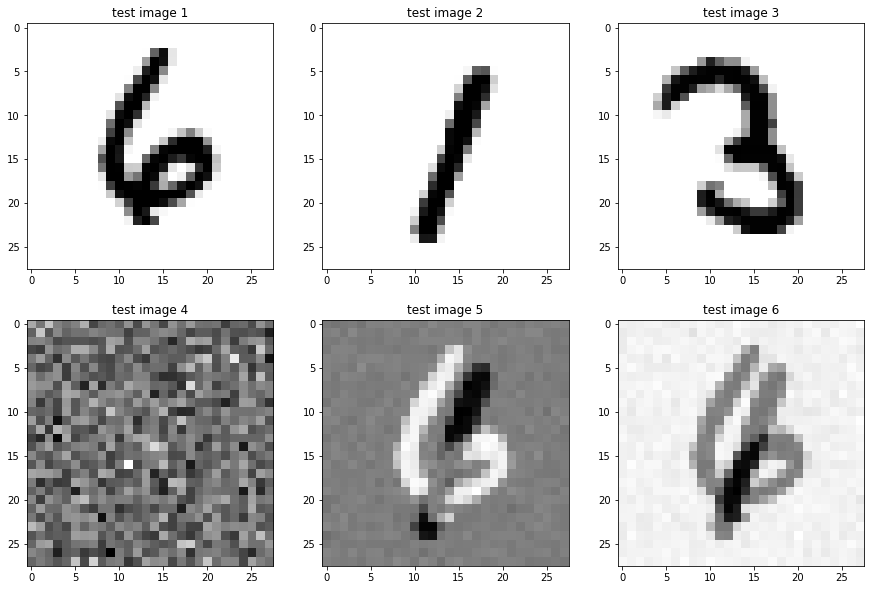

In [236]:
# Visualize some samples from the test dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1')
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2')
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3')
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4')
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5')
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6')
plt.show()

**Exercise 2: (Classifying OOD Data for a Toy Dataset)** In this Exercise, build a Logistic Regression model to distinguish between two classes in our toy classification dataset:

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)` 

In this dataset, the classes are balanced (we have 100 points in each class). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of test points,
`test_points`,
report the classification probabiliy for each test point under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test points, identify which of these test points are in-distribution and which ones are OOD.

Relate your analysis of the behaviour of Logistic Regression on this toy dataset to its performance on MNIST. Can you come up with some hypotheses for exactly when the classification probability indicates an inappropriate amount of certainty when predicting on test points?

In [240]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

In [292]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

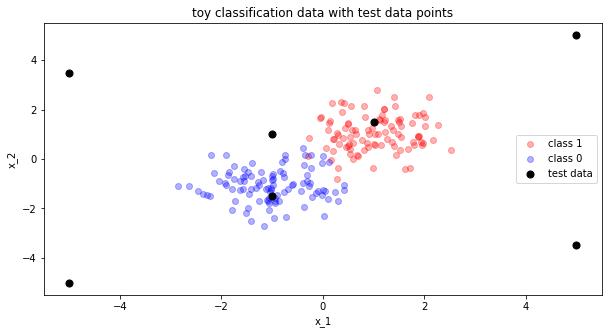

In [300]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

---

### Part II: Interpreting the Uncertainties of Bayesian Logistic Regression

**Exercise 3: (Classifying OOD Data for a Toy Dataset with Bayesian Logistic Regression)** 
In Exercise 2 and 3, we examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself (which decision boundaries can fit the dataset).

Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of the observations $(x_1^{(n)}, x_2^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$.

We suggest using the following settings for your HMC:

```python
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.hstack((logistic.coef_.flatten(), logistic.intercept_))
position_init = position_init.reshape((1, 3))
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 5000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1
```

where `logistic.coef_` and `logistic.intercept_` are the learned parameters of your `sklearn` Logistic regression model you trained in Exercise 3. 

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13). What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

**Exercise 4: (Epistemic Uncertainty from Bayesian Logistic Regression)** Since the posterior $p(\mathbf{w} | \mathcal{D}))$ is a distribution over multiple models (i.e. decision boundaries) and each model outputs a classification probability for each test data point, the posterior $p(\mathbf{w} | \mathcal{D}))$ defines a distribution of classification probabilities for each test point. The variance of the distribution over classification probabilities is one way of quantifying the amount of ***epistemic uncertainty*** - uncertainty due to lack of observed training data - of the model at a particular test point.

Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

**Exercise 5: (Classifying OOD Data for a Toy Dataset with Bayesian Non-linear Logistic Regression)** 
Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

Perform Bayesian Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, 10\, \mathbf{I})\\
Y^{(n)} &\sim Ber(\text{sigm}(\mathbf{w}^\top \phi(\mathbf{X}^{(n)}) ))
\end{align}

Visualize the decision boundaries corresponding to the samples in the posterior. Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

**Exercise 6: (Classifying OOD Data for a Toy Dataset with Bootstrap Non-linear Logistic Regression)** Perform bootstrap Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Obtain 100 bootstrap Logistic Regression models:
`LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`.

Visualize the decision boundaries corresponding to the samples in the bootstrap ensemble. Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.


### Part III: Broader Impact Analysis

**Exercise 7: (The Need for Useful Uncertainties in Classification)** Explain why OOD detection may be crucial for classifiers deployed in risk-adverse applications. Be concrete: choose a real-life domain application, identify the affected communities and the real-life consequences of an incorrect classification, explain *exactly* how OOD detection can help mitigate the risk of an incorrect classification. Feel free to use the following list of articles to help construct your answer.

**Reference:**
1. [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html)
2. [IBM Builds a More Diverse Million-Face Dataset to Help Reduce Bias in AI](https://techcrunch.com/2019/01/29/ibm-builds-a-more-diverse-million-face-dataset-to-help-reduce-bias-in-ai/)
3. [Wrongfully Accused by an Algorithm](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
4. [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/content/pnas/early/2020/05/19/1919012117.full.pdf)

**Exercise 8: (Comparing Bayesian and Frequnetist Epistemic Uncertainties)** In Homework #2, we saw that the epistemic uncertainties of frequentist and Bayesian uncertainties can be desirable or undesirable depending on the number of observations and the choices of hyperparameters (e.g. polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble). For Bayesian and frequentist ensembles of classifiers, based on empirical results above, conjecture which factors affect the quality of epistemic uncertainties of Bayesian and bootstrap ensemble classifiers, respectively. Support your answer with what we know about the properties of Logistic Regression models.

In order to obtain epistemic uncertainties that can distinguish in-distribution and OOD points, what settings of hyperparameters do we need for Bayesian and bootstrap ensemble classifiers, respectively?


**Exercise 10: (Is OOD Detection Enough for Risk Adverse Applications?)** In the risk adverse real-life application you identified in Exercise 1, is accurate OOD detection enough to mitigate unwanted outcomes of deploying our model? That is, when classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, what specific failure modes can these models experience? Are all of these failure modes addressed by proper detection of OOD inputs?